In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from keras.layers import Conv2D, Reshape
from keras.utils import Sequence
from keras.backend import epsilon

import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense,BatchNormalization, Flatten, MaxPool2D, MaxPooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import VGG16
import cv2


from tqdm.notebook import tqdm_notebook as tqdm

import os
from PIL import Image
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenetv2_preprocess_input
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet50_preprocess_input


In [39]:
print(os.listdir("./Dataset/"))
dataset_path = "./Dataset/real_and_fake_face_detection/real_and_fake_face"
test_dataset = "./Dataset/real_and_fake_face/"

['real_and_fake_face', 'real_and_fake_face_detection']


In [3]:
real = "./Dataset/real_and_fake_face_detection/real_and_fake_face/training_real/"
fake = "./Dataset/real_and_fake_face_detection/real_and_fake_face/training_fake/"

real_path = os.listdir(real)
fake_path = os.listdir(fake)

In [4]:
test_real = "./Dataset/real_and_fake_face/test_real/"
test_fake = "./Dataset/real_and_fake_face/test_fake/"

real_test = os.listdir(real)
fake_test = os.listdir(fake)

In [5]:
def load_img(path):
    image = cv2.imread(path)
    image = cv2.resize(image,(224, 224))
    return image[...,::-1]

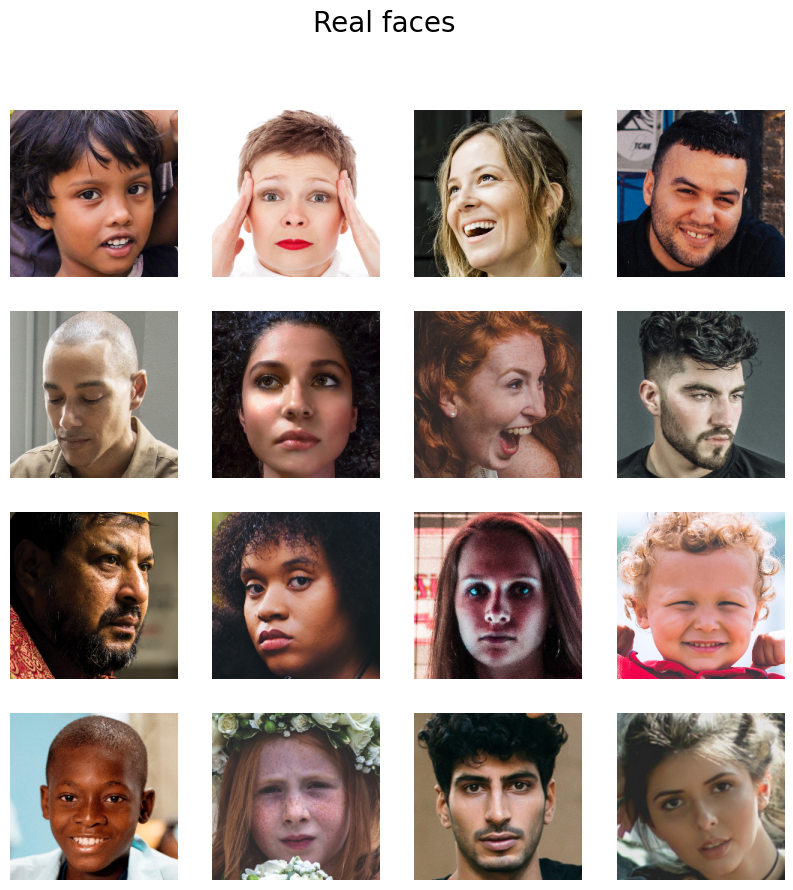

In [6]:
fig = plt.figure(figsize=(10, 10))

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(load_img(real + real_path[i]), cmap='gray')
    plt.suptitle("Real faces",fontsize=20)
    plt.axis('off')

plt.show()

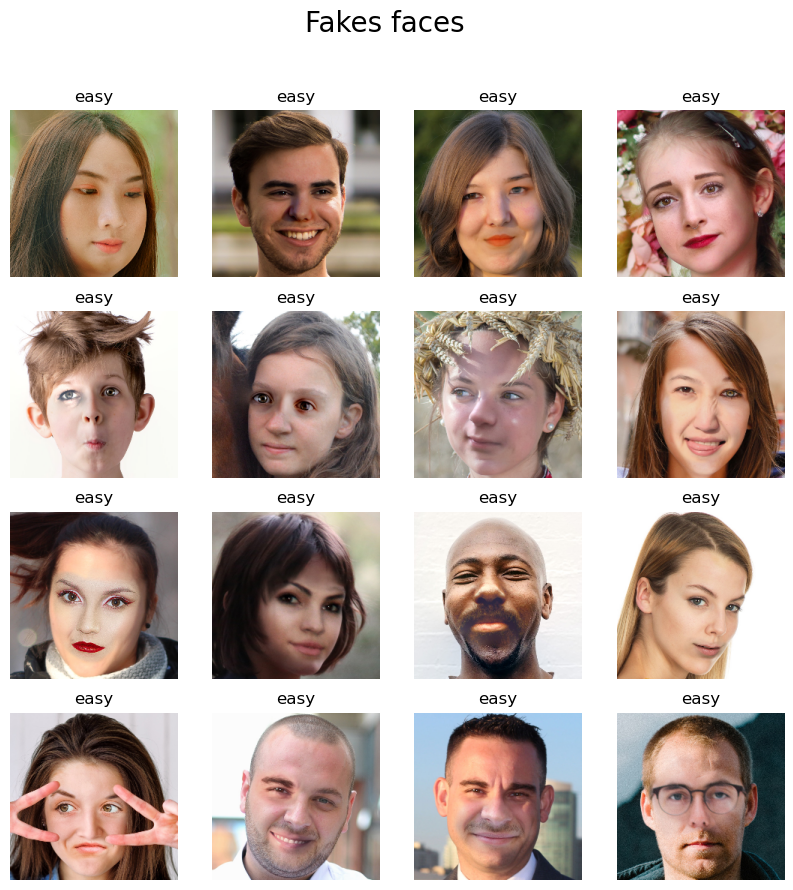

In [7]:
fig = plt.figure(figsize=(10,10))

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(load_img(fake + fake_path[i]), cmap='gray')
    plt.suptitle("Fakes faces",fontsize=20)
    plt.title(fake_path[i][:4])
    plt.axis('off')

plt.show()

In [8]:
#------------------------------------Pre Processing the image---------------------------------

In [9]:
# Set target size and batch size
target_size = (150, 150)
batch_size = 32

In [10]:
train_data_generator = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=False,
    rescale=1./255,
    validation_split=0.3
)

In [11]:
train_generator = train_data_generator.flow_from_directory(
    dataset_path,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary',
    subset="training"
)

Found 1429 images belonging to 2 classes.


In [12]:
validation_generator = train_data_generator.flow_from_directory(
    dataset_path,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary',
    subset="validation"
)

Found 612 images belonging to 2 classes.


In [42]:
test_generator = train_data_generator.flow_from_directory(
    test_dataset,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary',
    subset="training"
)

Found 1429 images belonging to 2 classes.


In [13]:
#-----------------------------------------Applying CNN Models----------------------------------

In [14]:
# Model - 1: Mobile Net 

mobile_net = MobileNetV2(
    input_shape=(150, 150, 3), 
    include_top=False, 
    weights='imagenet'
)

model1 = Sequential([
    mobile_net,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

In [15]:
# Compile and train Model 1
model1.compile(
    optimizer=Adam(learning_rate=0.0001), 
    loss='binary_crossentropy', 
    metrics=['accuracy']
)

model1.summary()

early_stopping_callback = EarlyStopping(
    patience=5, 
    restore_best_weights=True
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 2,422,081
Trainable params: 2,387,969
Non-

In [16]:
mobileNet_histroy = model1.fit(
    train_generator, 
    epochs=20, 
    validation_data=validation_generator, 
    callbacks=[early_stopping_callback]
)

Epoch 1/20
45/45 [==============================] - 104s 2s/step - loss: 0.7337 - accuracy: 0.5927 - val_loss: 1.4052 - val_accuracy: 0.4771
Epoch 2/20
45/45 [==============================] - 68s 2s/step - loss: 0.5170 - accuracy: 0.7432 - val_loss: 1.5494 - val_accuracy: 0.4804
Epoch 3/20
45/45 [==============================] - 66s 1s/step - loss: 0.3938 - accuracy: 0.8244 - val_loss: 1.3709 - val_accuracy: 0.5049
Epoch 4/20
45/45 [==============================] - 69s 2s/step - loss: 0.3068 - accuracy: 0.8698 - val_loss: 1.2471 - val_accuracy: 0.5343
Epoch 5/20
45/45 [==============================] - 63s 1s/step - loss: 0.2374 - accuracy: 0.9139 - val_loss: 1.2329 - val_accuracy: 0.5261
Epoch 6/20
45/45 [==============================] - 64s 1s/step - loss: 0.1552 - accuracy: 0.9454 - val_loss: 1.5830 - val_accuracy: 0.5408
Epoch 7/20
45/45 [==============================] - 66s 1s/step - loss: 0.0930 - accuracy: 0.9699 - val_loss: 1.6208 - val_accuracy: 0.5408
Epoch 8/20
45/45 [=

In [17]:
# # Model 2: Fast R-CNN (ResNet50)

# resnet = ResNet50(input_shape=(150, 150, 3), include_top=False, weights='imagenet')
# model2 = Sequential([
#     resnet,
#     GlobalAveragePooling2D(),
#     Dense(128, activation='relu'),
#     Dropout(0.5),
#     Dense(1, activation='sigmoid')
# ])

In [18]:
# # Compile and train Model 2
# model2.compile(
#     optimizer=Adam(learning_rate=0.0001), 
#     loss='binary_crossentropy', 
#     metrics=['accuracy']
# )
# model2.summary()

In [20]:
# RCNN_histroy = model2.fit(
#     train_generator, 
#     epochs=50, 
#     validation_data=validation_generator, 
#     callbacks=[early_stopping_callback]
# )

In [21]:
# Model 3 - VGG 16

base_model = VGG16(include_top=False, input_shape=(150, 150, 3))
model3 = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

In [22]:
# Freeze the weights of the base model (VGG16) during training
base_model.trainable = False

In [23]:
# Compile the Model
model3.compile(
    optimizer=Adam(learning_rate=0.0001), 
    loss='binary_crossentropy', 
    metrics=['accuracy']
)
model3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               2097408   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________


In [24]:
# Train the Model with EarlyStopping callback
VGG_histroy = model3.fit(
    train_generator, 
    epochs=10, 
    validation_data=validation_generator, 
    callbacks=[early_stopping_callback]
)

Epoch 1/10
45/45 [==============================] - 98s 2s/step - loss: 0.7184 - accuracy: 0.5913 - val_loss: 0.7477 - val_accuracy: 0.5507
Epoch 2/10
45/45 [==============================] - 91s 2s/step - loss: 0.6092 - accuracy: 0.6648 - val_loss: 0.7353 - val_accuracy: 0.5588
Epoch 3/10
45/45 [==============================] - 91s 2s/step - loss: 0.5704 - accuracy: 0.7138 - val_loss: 0.7231 - val_accuracy: 0.5784
Epoch 4/10
45/45 [==============================] - 92s 2s/step - loss: 0.5917 - accuracy: 0.6816 - val_loss: 0.7317 - val_accuracy: 0.5719
Epoch 5/10
45/45 [==============================] - 91s 2s/step - loss: 0.5450 - accuracy: 0.7271 - val_loss: 0.7451 - val_accuracy: 0.5866
Epoch 6/10
45/45 [==============================] - 91s 2s/step - loss: 0.5084 - accuracy: 0.7558 - val_loss: 0.7313 - val_accuracy: 0.5670
Epoch 7/10
45/45 [==============================] - 91s 2s/step - loss: 0.5085 - accuracy: 0.7544 - val_loss: 0.7481 - val_accuracy: 0.5670
Epoch 8/10
45/45 [==

In [25]:
# Model - 4: Custome Layered CNN 

model4 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

In [26]:
model4.compile(
    optimizer=Adam(learning_rate=0.0001), 
    loss='binary_crossentropy', 
    metrics=['accuracy']
)
model4.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)     

In [27]:
# Train the Model with EarlyStopping callback
custom_histroy = model4.fit(
    train_generator, 
    epochs=20, 
    validation_data=validation_generator, 
    callbacks=[early_stopping_callback]
)

Epoch 1/20
45/45 [==============================] - 36s 779ms/step - loss: 0.6964 - accuracy: 0.5171 - val_loss: 0.6934 - val_accuracy: 0.4935
Epoch 2/20
45/45 [==============================] - 35s 768ms/step - loss: 0.6799 - accuracy: 0.5759 - val_loss: 0.6906 - val_accuracy: 0.5180
Epoch 3/20
45/45 [==============================] - 35s 768ms/step - loss: 0.6589 - accuracy: 0.6186 - val_loss: 0.6938 - val_accuracy: 0.5147
Epoch 4/20
45/45 [==============================] - 35s 770ms/step - loss: 0.6415 - accuracy: 0.6298 - val_loss: 0.7063 - val_accuracy: 0.5605
Epoch 5/20
45/45 [==============================] - 35s 778ms/step - loss: 0.6286 - accuracy: 0.6396 - val_loss: 0.7217 - val_accuracy: 0.5425
Epoch 6/20
45/45 [==============================] - 35s 775ms/step - loss: 0.6163 - accuracy: 0.6725 - val_loss: 0.7102 - val_accuracy: 0.5327
Epoch 7/20
45/45 [==============================] - 35s 771ms/step - loss: 0.6140 - accuracy: 0.6571 - val_loss: 0.7355 - val_accuracy: 0.5507

In [28]:
#------------------------------Comparing the models---------------------------------------------

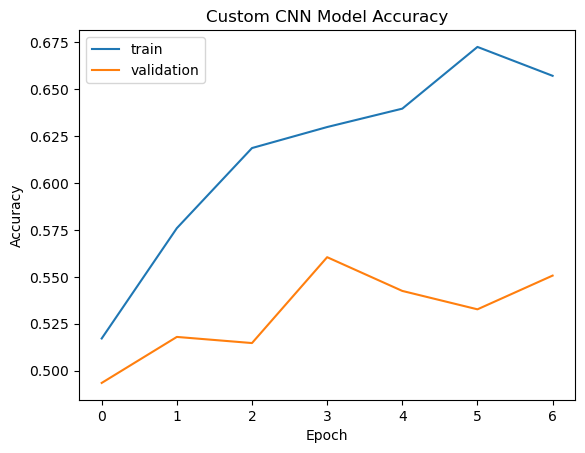

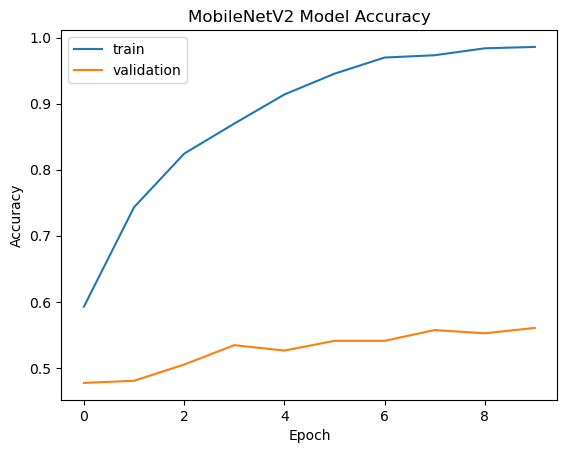

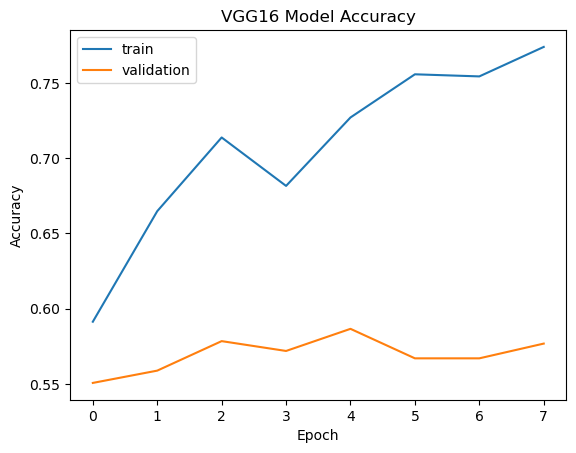

In [30]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Function to plot accuracy graphs
def plot_accuracy(history, model_name):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'{model_name} Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

# Plot accuracy graphs for all models
plot_accuracy(custom_histroy, 'Custom CNN')
plot_accuracy(mobileNet_histroy, 'MobileNetV2')
plot_accuracy(VGG_histroy, 'VGG16')
# plot_accuracy(RCNN_histroy, "RCNN")

In [31]:
test_image_path  = './Dataset/real_and_fake_face/test_fake/mid_65_1111.jpg'

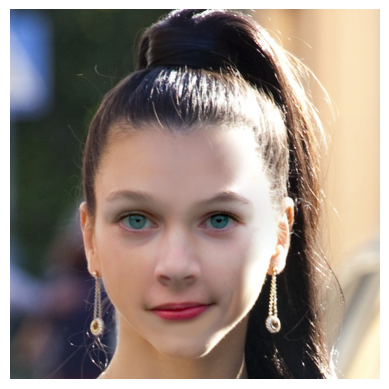

In [32]:
img = Image.open(test_image_path)
plt.imshow(img)
plt.axis('off')
plt.show()

In [33]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def test_image_vgg16(model, image_path):
    # Load and preprocess the image
    img = load_img(image_path, target_size=(150, 150))
    img_array = img_to_array(img)
    img_array = img_array.reshape((1, img_array.shape[0], img_array.shape[1], img_array.shape[2]))
    img_array = img_array / 255.0

    # Make prediction
    prediction = model.predict(img_array)

    # Interpret the prediction
    if prediction[0, 0] > 0.5:
        return "Real"
    else:
        return "Fake"

# Example usage:
prediction = test_image_vgg16(model3, test_image_path)
print("Prediction:", prediction)


1/1 [==============================] - 0s 191ms/step
Prediction: Fake


In [34]:
def test_image_mobilenetv2(model, image_path):
    # Load and preprocess the image
    img = load_img(image_path, target_size=(150, 150))
    img_array = img_to_array(img)
    img_array = img_array.reshape((1, img_array.shape[0], img_array.shape[1], img_array.shape[2]))
    img_array = mobilenetv2_preprocess_input(img_array)
    
    # Make prediction
    prediction = model.predict(img_array)

    # Interpret the prediction
    if prediction[0, 0] > 0.5:
        return "Real"
    else:
        return "Fake"

    
prediction = test_image_mobilenetv2(model1, test_image_path)
print("Prediction:", prediction)

1/1 [==============================] - 1s 554ms/step
Prediction: Fake


In [37]:
def test_image_custom_cnn(model, image_path):
    # Load and preprocess the image
    img = load_img(image_path, target_size=(150, 150))
    img_array = img_to_array(img)
    img_array = img_array.reshape((1, img_array.shape[0], img_array.shape[1], img_array.shape[2]))
    img_array = img_array / 255.0

    # Make prediction
    prediction = model.predict(img_array)

    # Interpret the prediction
    if prediction[0, 0] > 0.5:
        return "Real"
    else:
        return "Fake"

# Example usage:
prediction = test_image_custom_cnn(model4, test_image_path)
print("Prediction:", prediction)

1/1 [==============================] - 0s 62ms/step
Prediction: Fake


In [50]:
from glob import glob

# Get a list of all image files in the test directory
test_image_files = glob(os.path.join(test_dataset, '*', '*.jpg'))  # Update extension as needed

# Loop through each test image and make predictions
for image_path in test_image_files:
    preprocessed_image = preprocess_image(image_path)

    # Make predictions for each model
    prediction1 = model1.predict(preprocessed_image)
    prediction3 = model3.predict(preprocessed_image)
    prediction4 = model4.predict(preprocessed_image)

    # Interpret predictions
    prediction1_label = "Real" if prediction1[0, 0] > 0.5 else "Fake"
    prediction3_label = "Real" if prediction3[0, 0] > 0.5 else "Fake"
    prediction4_label = "Real" if prediction4[0, 0] > 0.5 else "Fake"

    print(f"Image: {image_path}")
    print("MobileNetV2 Label:", prediction1_label)
    print("VGG16 Label:", prediction3_label)
    print("Custom CNN Label:", prediction4_label)
    print("-----------------------------")


1/1 [==============================] - 0s 66ms/step
Image: ./Dataset/real_and_fake_face\test_fake\easy_100_1111.jpg
MobileNetV2 Label: Real
VGG16 Label: Real
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 28ms/step
Image: ./Dataset/real_and_fake_face\test_fake\easy_101_0010.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 23ms/step
Image: ./Dataset/real_and_fake_face\test_fake\easy_102_0101.jpg
MobileNetV2 Label: Real
VGG16 Label: Real
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 21ms/step
Image: ./Dataset/real_and_fake_face\test_fake\easy_103_1111.jpg
MobileNetV2 Label: Fake
VGG16 Label: Real
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 36ms/step
Image: ./Dataset/real_and_fake_face\test_fake\easy_104_1000.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fak

1/1 [==============================] - 0s 21ms/step
Image: ./Dataset/real_and_fake_face\test_fake\easy_120_0011.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 21ms/step
Image: ./Dataset/real_and_fake_face\test_fake\easy_121_0011.jpg
MobileNetV2 Label: Fake
VGG16 Label: Real
Custom CNN Label: Fake
-----------------------------
1/1 [==============================] - 0s 14ms/step
Image: ./Dataset/real_and_fake_face\test_fake\easy_122_1011.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom CNN Label: Fake
-----------------------------
1/1 [==============================] - 0s 20ms/step
Image: ./Dataset/real_and_fake_face\test_fake\easy_123_0100.jpg
MobileNetV2 Label: Real
VGG16 Label: Fake
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 31ms/step
Image: ./Dataset/real_and_fake_face\test_fake\easy_124_1110.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fak

1/1 [==============================] - 0s 20ms/step
Image: ./Dataset/real_and_fake_face\test_fake\easy_144_1111.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom CNN Label: Fake
-----------------------------
1/1 [==============================] - 0s 27ms/step
Image: ./Dataset/real_and_fake_face\test_fake\easy_145_1000.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 21ms/step
Image: ./Dataset/real_and_fake_face\test_fake\easy_146_1110.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 22ms/step
Image: ./Dataset/real_and_fake_face\test_fake\easy_147_1110.jpg
MobileNetV2 Label: Fake
VGG16 Label: Real
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 24ms/step
Image: ./Dataset/real_and_fake_face\test_fake\easy_148_0011.jpg
MobileNetV2 Label: Real
VGG16 Label: Rea

1/1 [==============================] - 0s 20ms/step
Image: ./Dataset/real_and_fake_face\test_fake\easy_168_0010.jpg
MobileNetV2 Label: Fake
VGG16 Label: Real
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 24ms/step
Image: ./Dataset/real_and_fake_face\test_fake\easy_169_1100.jpg
MobileNetV2 Label: Fake
VGG16 Label: Real
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 21ms/step
Image: ./Dataset/real_and_fake_face\test_fake\easy_16_1111.jpg
MobileNetV2 Label: Real
VGG16 Label: Real
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 27ms/step
Image: ./Dataset/real_and_fake_face\test_fake\easy_170_0010.jpg
MobileNetV2 Label: Fake
VGG16 Label: Real
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 17ms/step
Image: ./Dataset/real_and_fake_face\test_fake\easy_171_1100.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake

1/1 [==============================] - 0s 21ms/step
Image: ./Dataset/real_and_fake_face\test_fake\easy_191_0001.jpg
MobileNetV2 Label: Real
VGG16 Label: Real
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 20ms/step
Image: ./Dataset/real_and_fake_face\test_fake\easy_192_1000.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom CNN Label: Fake
-----------------------------
1/1 [==============================] - 0s 21ms/step
Image: ./Dataset/real_and_fake_face\test_fake\easy_193_1110.jpg
MobileNetV2 Label: Fake
VGG16 Label: Real
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 20ms/step
Image: ./Dataset/real_and_fake_face\test_fake\easy_194_1011.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 21ms/step
Image: ./Dataset/real_and_fake_face\test_fake\easy_195_1110.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fak

1/1 [==============================] - 0s 25ms/step
Image: ./Dataset/real_and_fake_face\test_fake\easy_214_0011.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 21ms/step
Image: ./Dataset/real_and_fake_face\test_fake\easy_215_1111.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 20ms/step
Image: ./Dataset/real_and_fake_face\test_fake\easy_216_1100.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 20ms/step
Image: ./Dataset/real_and_fake_face\test_fake\easy_217_1111.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 20ms/step
Image: ./Dataset/real_and_fake_face\test_fake\easy_218_0011.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fak

1/1 [==============================] - 0s 19ms/step
Image: ./Dataset/real_and_fake_face\test_fake\easy_238_1111.jpg
MobileNetV2 Label: Fake
VGG16 Label: Real
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 19ms/step
Image: ./Dataset/real_and_fake_face\test_fake\easy_239_1110.jpg
MobileNetV2 Label: Fake
VGG16 Label: Real
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 21ms/step
Image: ./Dataset/real_and_fake_face\test_fake\easy_23_1100.jpg
MobileNetV2 Label: Real
VGG16 Label: Fake
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 21ms/step
Image: ./Dataset/real_and_fake_face\test_fake\easy_240_1110.jpg
MobileNetV2 Label: Fake
VGG16 Label: Real
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 15ms/step
Image: ./Dataset/real_and_fake_face\test_fake\easy_24_0011.jpg
MobileNetV2 Label: Fake
VGG16 Label: Real


1/1 [==============================] - 0s 19ms/step
Image: ./Dataset/real_and_fake_face\test_fake\easy_44_0011.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 20ms/step
Image: ./Dataset/real_and_fake_face\test_fake\easy_45_1010.jpg
MobileNetV2 Label: Fake
VGG16 Label: Real
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 21ms/step
Image: ./Dataset/real_and_fake_face\test_fake\easy_46_1100.jpg
MobileNetV2 Label: Real
VGG16 Label: Fake
Custom CNN Label: Fake
-----------------------------
1/1 [==============================] - 0s 20ms/step
Image: ./Dataset/real_and_fake_face\test_fake\easy_47_1110.jpg
MobileNetV2 Label: Real
VGG16 Label: Fake
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 21ms/step
Image: ./Dataset/real_and_fake_face\test_fake\easy_48_0011.jpg
MobileNetV2 Label: Real
VGG16 Label: Real
Cus

1/1 [==============================] - 0s 19ms/step
Image: ./Dataset/real_and_fake_face\test_fake\easy_68_1100.jpg
MobileNetV2 Label: Fake
VGG16 Label: Real
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 20ms/step
Image: ./Dataset/real_and_fake_face\test_fake\easy_69_1011.jpg
MobileNetV2 Label: Real
VGG16 Label: Fake
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 20ms/step
Image: ./Dataset/real_and_fake_face\test_fake\easy_6_1110.jpg
MobileNetV2 Label: Real
VGG16 Label: Fake
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 19ms/step
Image: ./Dataset/real_and_fake_face\test_fake\easy_70_0011.jpg
MobileNetV2 Label: Fake
VGG16 Label: Real
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 19ms/step
Image: ./Dataset/real_and_fake_face\test_fake\easy_71_1100.jpg
MobileNetV2 Label: Real
VGG16 Label: Fake
Cust

1/1 [==============================] - 0s 19ms/step
Image: ./Dataset/real_and_fake_face\test_fake\easy_91_1000.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 20ms/step
Image: ./Dataset/real_and_fake_face\test_fake\easy_92_0011.jpg
MobileNetV2 Label: Fake
VGG16 Label: Real
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 21ms/step
Image: ./Dataset/real_and_fake_face\test_fake\easy_93_1010.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 20ms/step
Image: ./Dataset/real_and_fake_face\test_fake\easy_94_0001.jpg
MobileNetV2 Label: Fake
VGG16 Label: Real
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 19ms/step
Image: ./Dataset/real_and_fake_face\test_fake\easy_95_0101.jpg
MobileNetV2 Label: Fake
VGG16 Label: Real
Cus

1/1 [==============================] - 0s 20ms/step
Image: ./Dataset/real_and_fake_face\test_fake\hard_115_1110.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 24ms/step
Image: ./Dataset/real_and_fake_face\test_fake\hard_116_1101.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 18ms/step
Image: ./Dataset/real_and_fake_face\test_fake\hard_117_1110.jpg
MobileNetV2 Label: Real
VGG16 Label: Real
Custom CNN Label: Fake
-----------------------------
1/1 [==============================] - 0s 13ms/step
Image: ./Dataset/real_and_fake_face\test_fake\hard_118_0111.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 19ms/step
Image: ./Dataset/real_and_fake_face\test_fake\hard_119_1100.jpg
MobileNetV2 Label: Real
VGG16 Label: Fak

1/1 [==============================] - 0s 20ms/step
Image: ./Dataset/real_and_fake_face\test_fake\hard_139_1011.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 21ms/step
Image: ./Dataset/real_and_fake_face\test_fake\hard_13_1111.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom CNN Label: Fake
-----------------------------
1/1 [==============================] - 0s 21ms/step
Image: ./Dataset/real_and_fake_face\test_fake\hard_140_1111.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 18ms/step
Image: ./Dataset/real_and_fake_face\test_fake\hard_141_0100.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 18ms/step
Image: ./Dataset/real_and_fake_face\test_fake\hard_142_1110.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake

1/1 [==============================] - 0s 26ms/step
Image: ./Dataset/real_and_fake_face\test_fake\hard_162_0010.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 17ms/step
Image: ./Dataset/real_and_fake_face\test_fake\hard_163_0011.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 19ms/step
Image: ./Dataset/real_and_fake_face\test_fake\hard_164_1000.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 16ms/step
Image: ./Dataset/real_and_fake_face\test_fake\hard_165_1000.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 19ms/step
Image: ./Dataset/real_and_fake_face\test_fake\hard_166_1110.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fak

1/1 [==============================] - 0s 20ms/step
Image: ./Dataset/real_and_fake_face\test_fake\hard_186_0011.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 20ms/step
Image: ./Dataset/real_and_fake_face\test_fake\hard_187_0100.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom CNN Label: Fake
-----------------------------
1/1 [==============================] - 0s 20ms/step
Image: ./Dataset/real_and_fake_face\test_fake\hard_188_0100.jpg
MobileNetV2 Label: Fake
VGG16 Label: Real
Custom CNN Label: Fake
-----------------------------
1/1 [==============================] - 0s 22ms/step
Image: ./Dataset/real_and_fake_face\test_fake\hard_189_0011.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 26ms/step
Image: ./Dataset/real_and_fake_face\test_fake\hard_18_1111.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake

1/1 [==============================] - 0s 29ms/step
Image: ./Dataset/real_and_fake_face\test_fake\hard_209_1011.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 17ms/step
Image: ./Dataset/real_and_fake_face\test_fake\hard_20_1111.jpg
MobileNetV2 Label: Fake
VGG16 Label: Real
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 28ms/step
Image: ./Dataset/real_and_fake_face\test_fake\hard_210_1100.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 21ms/step
Image: ./Dataset/real_and_fake_face\test_fake\hard_211_0110.jpg
MobileNetV2 Label: Real
VGG16 Label: Fake
Custom CNN Label: Fake
-----------------------------
1/1 [==============================] - 0s 18ms/step
Image: ./Dataset/real_and_fake_face\test_fake\hard_212_1101.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake

1/1 [==============================] - 0s 21ms/step
Image: ./Dataset/real_and_fake_face\test_fake\hard_232_0001.jpg
MobileNetV2 Label: Real
VGG16 Label: Fake
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 21ms/step
Image: ./Dataset/real_and_fake_face\test_fake\hard_233_0010.jpg
MobileNetV2 Label: Real
VGG16 Label: Fake
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 19ms/step
Image: ./Dataset/real_and_fake_face\test_fake\hard_234_1100.jpg
MobileNetV2 Label: Fake
VGG16 Label: Real
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 24ms/step
Image: ./Dataset/real_and_fake_face\test_fake\hard_235_0001.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 21ms/step
Image: ./Dataset/real_and_fake_face\test_fake\hard_236_1001.jpg
MobileNetV2 Label: Real
VGG16 Label: Fak

1/1 [==============================] - 0s 19ms/step
Image: ./Dataset/real_and_fake_face\test_fake\hard_39_1111.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 22ms/step
Image: ./Dataset/real_and_fake_face\test_fake\hard_3_1111.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 20ms/step
Image: ./Dataset/real_and_fake_face\test_fake\hard_40_1111.jpg
MobileNetV2 Label: Fake
VGG16 Label: Real
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 25ms/step
Image: ./Dataset/real_and_fake_face\test_fake\hard_41_1111.jpg
MobileNetV2 Label: Fake
VGG16 Label: Real
Custom CNN Label: Fake
-----------------------------
1/1 [==============================] - 0s 21ms/step
Image: ./Dataset/real_and_fake_face\test_fake\hard_42_1111.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Cust

1/1 [==============================] - 0s 20ms/step
Image: ./Dataset/real_and_fake_face\test_fake\hard_62_1010.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 19ms/step
Image: ./Dataset/real_and_fake_face\test_fake\hard_63_1101.jpg
MobileNetV2 Label: Real
VGG16 Label: Fake
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 20ms/step
Image: ./Dataset/real_and_fake_face\test_fake\hard_64_0010.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 19ms/step
Image: ./Dataset/real_and_fake_face\test_fake\hard_65_0101.jpg
MobileNetV2 Label: Real
VGG16 Label: Fake
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 20ms/step
Image: ./Dataset/real_and_fake_face\test_fake\hard_66_1111.jpg
MobileNetV2 Label: Fake
VGG16 Label: Real
Cus

1/1 [==============================] - 0s 26ms/step
Image: ./Dataset/real_and_fake_face\test_fake\hard_86_1100.jpg
MobileNetV2 Label: Real
VGG16 Label: Fake
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 20ms/step
Image: ./Dataset/real_and_fake_face\test_fake\hard_87_1111.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 20ms/step
Image: ./Dataset/real_and_fake_face\test_fake\hard_88_1111.jpg
MobileNetV2 Label: Real
VGG16 Label: Real
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 21ms/step
Image: ./Dataset/real_and_fake_face\test_fake\hard_89_1110.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 20ms/step
Image: ./Dataset/real_and_fake_face\test_fake\hard_8_1000.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Cust

1/1 [==============================] - 0s 19ms/step
Image: ./Dataset/real_and_fake_face\test_fake\mid_10_1111.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom CNN Label: Fake
-----------------------------
1/1 [==============================] - 0s 17ms/step
Image: ./Dataset/real_and_fake_face\test_fake\mid_110_1100.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 20ms/step
Image: ./Dataset/real_and_fake_face\test_fake\mid_111_0001.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 18ms/step
Image: ./Dataset/real_and_fake_face\test_fake\mid_112_0001.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 18ms/step
Image: ./Dataset/real_and_fake_face\test_fake\mid_113_1100.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Cust

1/1 [==============================] - 0s 20ms/step
Image: ./Dataset/real_and_fake_face\test_fake\mid_133_1001.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 22ms/step
Image: ./Dataset/real_and_fake_face\test_fake\mid_134_1010.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 20ms/step
Image: ./Dataset/real_and_fake_face\test_fake\mid_135_1110.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 20ms/step
Image: ./Dataset/real_and_fake_face\test_fake\mid_136_0001.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 17ms/step
Image: ./Dataset/real_and_fake_face\test_fake\mid_137_1011.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Cus

1/1 [==============================] - 0s 21ms/step
Image: ./Dataset/real_and_fake_face\test_fake\mid_157_1111.jpg
MobileNetV2 Label: Fake
VGG16 Label: Real
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 26ms/step
Image: ./Dataset/real_and_fake_face\test_fake\mid_158_1010.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 21ms/step
Image: ./Dataset/real_and_fake_face\test_fake\mid_159_1111.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom CNN Label: Fake
-----------------------------
1/1 [==============================] - 0s 20ms/step
Image: ./Dataset/real_and_fake_face\test_fake\mid_15_1111.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom CNN Label: Fake
-----------------------------
1/1 [==============================] - 0s 19ms/step
Image: ./Dataset/real_and_fake_face\test_fake\mid_160_1110.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Cust

1/1 [==============================] - 0s 18ms/step
Image: ./Dataset/real_and_fake_face\test_fake\mid_180_1110.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom CNN Label: Fake
-----------------------------
1/1 [==============================] - 0s 21ms/step
Image: ./Dataset/real_and_fake_face\test_fake\mid_181_0011.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 21ms/step
Image: ./Dataset/real_and_fake_face\test_fake\mid_182_1111.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 20ms/step
Image: ./Dataset/real_and_fake_face\test_fake\mid_183_1111.jpg
MobileNetV2 Label: Fake
VGG16 Label: Real
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 21ms/step
Image: ./Dataset/real_and_fake_face\test_fake\mid_184_1101.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Cus

1/1 [==============================] - 0s 20ms/step
Image: ./Dataset/real_and_fake_face\test_fake\mid_203_1111.jpg
MobileNetV2 Label: Real
VGG16 Label: Fake
Custom CNN Label: Fake
-----------------------------
1/1 [==============================] - 0s 21ms/step
Image: ./Dataset/real_and_fake_face\test_fake\mid_204_1111.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 21ms/step
Image: ./Dataset/real_and_fake_face\test_fake\mid_205_0011.jpg
MobileNetV2 Label: Fake
VGG16 Label: Real
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 21ms/step
Image: ./Dataset/real_and_fake_face\test_fake\mid_206_1111.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 20ms/step
Image: ./Dataset/real_and_fake_face\test_fake\mid_207_1111.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Cus

1/1 [==============================] - 0s 20ms/step
Image: ./Dataset/real_and_fake_face\test_fake\mid_227_1111.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom CNN Label: Fake
-----------------------------
1/1 [==============================] - 0s 21ms/step
Image: ./Dataset/real_and_fake_face\test_fake\mid_228_1111.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom CNN Label: Fake
-----------------------------
1/1 [==============================] - 0s 19ms/step
Image: ./Dataset/real_and_fake_face\test_fake\mid_229_1111.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 20ms/step
Image: ./Dataset/real_and_fake_face\test_fake\mid_22_1101.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom CNN Label: Fake
-----------------------------
1/1 [==============================] - 0s 20ms/step
Image: ./Dataset/real_and_fake_face\test_fake\mid_230_1110.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Cust

1/1 [==============================] - 0s 20ms/step
Image: ./Dataset/real_and_fake_face\test_fake\mid_250_1111.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom CNN Label: Fake
-----------------------------
1/1 [==============================] - 0s 20ms/step
Image: ./Dataset/real_and_fake_face\test_fake\mid_251_1111.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom CNN Label: Fake
-----------------------------
1/1 [==============================] - 0s 20ms/step
Image: ./Dataset/real_and_fake_face\test_fake\mid_252_1101.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 20ms/step
Image: ./Dataset/real_and_fake_face\test_fake\mid_253_0101.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom CNN Label: Fake
-----------------------------
1/1 [==============================] - 0s 20ms/step
Image: ./Dataset/real_and_fake_face\test_fake\mid_254_1111.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Cus

1/1 [==============================] - 0s 20ms/step
Image: ./Dataset/real_and_fake_face\test_fake\mid_274_1100.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom CNN Label: Fake
-----------------------------
1/1 [==============================] - 0s 19ms/step
Image: ./Dataset/real_and_fake_face\test_fake\mid_275_1100.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 14ms/step
Image: ./Dataset/real_and_fake_face\test_fake\mid_276_0011.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 21ms/step
Image: ./Dataset/real_and_fake_face\test_fake\mid_277_1100.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom CNN Label: Fake
-----------------------------
1/1 [==============================] - 0s 21ms/step
Image: ./Dataset/real_and_fake_face\test_fake\mid_278_1101.jpg
MobileNetV2 Label: Real
VGG16 Label: Fake
Cus

1/1 [==============================] - 0s 21ms/step
Image: ./Dataset/real_and_fake_face\test_fake\mid_298_0001.jpg
MobileNetV2 Label: Real
VGG16 Label: Fake
Custom CNN Label: Fake
-----------------------------
1/1 [==============================] - 0s 21ms/step
Image: ./Dataset/real_and_fake_face\test_fake\mid_299_1100.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom CNN Label: Fake
-----------------------------
1/1 [==============================] - 0s 28ms/step
Image: ./Dataset/real_and_fake_face\test_fake\mid_29_1111.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom CNN Label: Fake
-----------------------------
1/1 [==============================] - 0s 20ms/step
Image: ./Dataset/real_and_fake_face\test_fake\mid_2_1101.jpg
MobileNetV2 Label: Real
VGG16 Label: Fake
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 15ms/step
Image: ./Dataset/real_and_fake_face\test_fake\mid_300_0111.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom

1/1 [==============================] - 0s 28ms/step
Image: ./Dataset/real_and_fake_face\test_fake\mid_320_1111.jpg
MobileNetV2 Label: Fake
VGG16 Label: Real
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 21ms/step
Image: ./Dataset/real_and_fake_face\test_fake\mid_321_1110.jpg
MobileNetV2 Label: Fake
VGG16 Label: Real
Custom CNN Label: Fake
-----------------------------
1/1 [==============================] - 0s 29ms/step
Image: ./Dataset/real_and_fake_face\test_fake\mid_322_1111.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom CNN Label: Fake
-----------------------------
1/1 [==============================] - 0s 20ms/step
Image: ./Dataset/real_and_fake_face\test_fake\mid_323_1101.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom CNN Label: Fake
-----------------------------
1/1 [==============================] - 0s 20ms/step
Image: ./Dataset/real_and_fake_face\test_fake\mid_324_1111.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Cus

1/1 [==============================] - 0s 21ms/step
Image: ./Dataset/real_and_fake_face\test_fake\mid_344_0010.jpg
MobileNetV2 Label: Fake
VGG16 Label: Real
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 21ms/step
Image: ./Dataset/real_and_fake_face\test_fake\mid_345_1111.jpg
MobileNetV2 Label: Fake
VGG16 Label: Real
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 21ms/step
Image: ./Dataset/real_and_fake_face\test_fake\mid_346_0011.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom CNN Label: Fake
-----------------------------
1/1 [==============================] - 0s 21ms/step
Image: ./Dataset/real_and_fake_face\test_fake\mid_347_0011.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 20ms/step
Image: ./Dataset/real_and_fake_face\test_fake\mid_348_1100.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Cus

1/1 [==============================] - 0s 28ms/step
Image: ./Dataset/real_and_fake_face\test_fake\mid_368_0110.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 22ms/step
Image: ./Dataset/real_and_fake_face\test_fake\mid_369_1110.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 20ms/step
Image: ./Dataset/real_and_fake_face\test_fake\mid_36_1100.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 21ms/step
Image: ./Dataset/real_and_fake_face\test_fake\mid_370_1111.jpg
MobileNetV2 Label: Fake
VGG16 Label: Real
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 20ms/step
Image: ./Dataset/real_and_fake_face\test_fake\mid_371_0011.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Cust

1/1 [==============================] - 0s 21ms/step
Image: ./Dataset/real_and_fake_face\test_fake\mid_391_1110.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 21ms/step
Image: ./Dataset/real_and_fake_face\test_fake\mid_392_1111.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 29ms/step
Image: ./Dataset/real_and_fake_face\test_fake\mid_393_1101.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom CNN Label: Fake
-----------------------------
1/1 [==============================] - 0s 21ms/step
Image: ./Dataset/real_and_fake_face\test_fake\mid_394_1111.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 20ms/step
Image: ./Dataset/real_and_fake_face\test_fake\mid_395_1110.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Cus

1/1 [==============================] - 0s 21ms/step
Image: ./Dataset/real_and_fake_face\test_fake\mid_414_0011.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 18ms/step
Image: ./Dataset/real_and_fake_face\test_fake\mid_415_1111.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom CNN Label: Fake
-----------------------------
1/1 [==============================] - 0s 20ms/step
Image: ./Dataset/real_and_fake_face\test_fake\mid_416_1111.jpg
MobileNetV2 Label: Fake
VGG16 Label: Real
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 19ms/step
Image: ./Dataset/real_and_fake_face\test_fake\mid_417_1111.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 19ms/step
Image: ./Dataset/real_and_fake_face\test_fake\mid_418_1101.jpg
MobileNetV2 Label: Real
VGG16 Label: Fake
Cus

1/1 [==============================] - 0s 20ms/step
Image: ./Dataset/real_and_fake_face\test_fake\mid_438_0010.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 19ms/step
Image: ./Dataset/real_and_fake_face\test_fake\mid_439_1000.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom CNN Label: Fake
-----------------------------
1/1 [==============================] - 0s 21ms/step
Image: ./Dataset/real_and_fake_face\test_fake\mid_43_1111.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 29ms/step
Image: ./Dataset/real_and_fake_face\test_fake\mid_440_0101.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 25ms/step
Image: ./Dataset/real_and_fake_face\test_fake\mid_441_0011.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Cust

1/1 [==============================] - 0s 21ms/step
Image: ./Dataset/real_and_fake_face\test_fake\mid_461_1100.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 21ms/step
Image: ./Dataset/real_and_fake_face\test_fake\mid_462_1101.jpg
MobileNetV2 Label: Fake
VGG16 Label: Real
Custom CNN Label: Fake
-----------------------------
1/1 [==============================] - 0s 27ms/step
Image: ./Dataset/real_and_fake_face\test_fake\mid_463_0100.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom CNN Label: Fake
-----------------------------
1/1 [==============================] - 0s 21ms/step
Image: ./Dataset/real_and_fake_face\test_fake\mid_464_1111.jpg
MobileNetV2 Label: Real
VGG16 Label: Fake
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 26ms/step
Image: ./Dataset/real_and_fake_face\test_fake\mid_465_1111.jpg
MobileNetV2 Label: Fake
VGG16 Label: Real
Cus

1/1 [==============================] - 0s 26ms/step
Image: ./Dataset/real_and_fake_face\test_fake\mid_51_1111.jpg
MobileNetV2 Label: Fake
VGG16 Label: Real
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 19ms/step
Image: ./Dataset/real_and_fake_face\test_fake\mid_52_1111.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 28ms/step
Image: ./Dataset/real_and_fake_face\test_fake\mid_53_1100.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom CNN Label: Fake
-----------------------------
1/1 [==============================] - 0s 21ms/step
Image: ./Dataset/real_and_fake_face\test_fake\mid_54_1111.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 20ms/step
Image: ./Dataset/real_and_fake_face\test_fake\mid_55_1111.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom C

1/1 [==============================] - 0s 20ms/step
Image: ./Dataset/real_and_fake_face\test_fake\mid_75_1111.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 20ms/step
Image: ./Dataset/real_and_fake_face\test_fake\mid_76_1111.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 21ms/step
Image: ./Dataset/real_and_fake_face\test_fake\mid_77_1110.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 21ms/step
Image: ./Dataset/real_and_fake_face\test_fake\mid_78_1101.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 20ms/step
Image: ./Dataset/real_and_fake_face\test_fake\mid_79_1111.jpg
MobileNetV2 Label: Real
VGG16 Label: Fake
Custom C

1/1 [==============================] - 0s 19ms/step
Image: ./Dataset/real_and_fake_face\test_fake\mid_99_1100.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 20ms/step
Image: ./Dataset/real_and_fake_face\test_fake\mid_9_1110.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom CNN Label: Fake
-----------------------------
1/1 [==============================] - 0s 26ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00001.jpg
MobileNetV2 Label: Fake
VGG16 Label: Real
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 20ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00002.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom CNN Label: Fake
-----------------------------
1/1 [==============================] - 0s 20ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00003.jpg
MobileNetV2 Label: Real
VGG16 Label: Real
Custom CNN L

1/1 [==============================] - 0s 21ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00026.jpg
MobileNetV2 Label: Real
VGG16 Label: Fake
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 20ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00027.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 21ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00028.jpg
MobileNetV2 Label: Fake
VGG16 Label: Real
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 21ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00029.jpg
MobileNetV2 Label: Real
VGG16 Label: Real
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 21ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00030.jpg
MobileNetV2 Label: Fake
VGG16 Label: Real
Custom CNN La

1/1 [==============================] - 0s 26ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00052.jpg
MobileNetV2 Label: Real
VGG16 Label: Fake
Custom CNN Label: Fake
-----------------------------
1/1 [==============================] - 0s 22ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00053.jpg
MobileNetV2 Label: Real
VGG16 Label: Real
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 22ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00054.jpg
MobileNetV2 Label: Fake
VGG16 Label: Real
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 20ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00055.jpg
MobileNetV2 Label: Fake
VGG16 Label: Real
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 21ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00056.jpg
MobileNetV2 Label: Fake
VGG16 Label: Real
Custom CNN La

1/1 [==============================] - 0s 41ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00078.jpg
MobileNetV2 Label: Real
VGG16 Label: Real
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 25ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00079.jpg
MobileNetV2 Label: Fake
VGG16 Label: Real
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 19ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00080.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 21ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00081.jpg
MobileNetV2 Label: Fake
VGG16 Label: Real
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 20ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00082.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom CNN La

1/1 [==============================] - 0s 21ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00105.jpg
MobileNetV2 Label: Real
VGG16 Label: Real
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 21ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00106.jpg
MobileNetV2 Label: Real
VGG16 Label: Real
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 21ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00107.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom CNN Label: Fake
-----------------------------
1/1 [==============================] - 0s 21ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00108.jpg
MobileNetV2 Label: Real
VGG16 Label: Real
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 25ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00109.jpg
MobileNetV2 Label: Real
VGG16 Label: Fake
Custom CNN La

1/1 [==============================] - 0s 19ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00131.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 21ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00132.jpg
MobileNetV2 Label: Real
VGG16 Label: Fake
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 20ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00133.jpg
MobileNetV2 Label: Fake
VGG16 Label: Real
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 20ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00134.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 21ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00135.jpg
MobileNetV2 Label: Real
VGG16 Label: Real
Custom CNN La

1/1 [==============================] - 0s 20ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00157.jpg
MobileNetV2 Label: Fake
VGG16 Label: Real
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 20ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00158.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 20ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00159.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom CNN Label: Fake
-----------------------------
1/1 [==============================] - 0s 18ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00160.jpg
MobileNetV2 Label: Fake
VGG16 Label: Real
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 20ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00161.jpg
MobileNetV2 Label: Real
VGG16 Label: Real
Custom CNN La

1/1 [==============================] - 0s 21ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00184.jpg
MobileNetV2 Label: Fake
VGG16 Label: Real
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 21ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00185.jpg
MobileNetV2 Label: Fake
VGG16 Label: Real
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 18ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00186.jpg
MobileNetV2 Label: Fake
VGG16 Label: Real
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 21ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00187.jpg
MobileNetV2 Label: Real
VGG16 Label: Real
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 20ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00188.jpg
MobileNetV2 Label: Fake
VGG16 Label: Real
Custom CNN La

1/1 [==============================] - 0s 26ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00210.jpg
MobileNetV2 Label: Fake
VGG16 Label: Real
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 21ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00211.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 21ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00212.jpg
MobileNetV2 Label: Fake
VGG16 Label: Real
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 20ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00213.jpg
MobileNetV2 Label: Fake
VGG16 Label: Real
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 20ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00214.jpg
MobileNetV2 Label: Fake
VGG16 Label: Real
Custom CNN La

1/1 [==============================] - 0s 20ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00236.jpg
MobileNetV2 Label: Fake
VGG16 Label: Real
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 22ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00237.jpg
MobileNetV2 Label: Fake
VGG16 Label: Real
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 21ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00238.jpg
MobileNetV2 Label: Real
VGG16 Label: Real
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 21ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00239.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom CNN Label: Fake
-----------------------------
1/1 [==============================] - 0s 21ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00240.jpg
MobileNetV2 Label: Fake
VGG16 Label: Real
Custom CNN La

1/1 [==============================] - 0s 19ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00263.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 20ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00264.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 22ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00265.jpg
MobileNetV2 Label: Real
VGG16 Label: Real
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 28ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00266.jpg
MobileNetV2 Label: Real
VGG16 Label: Real
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 20ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00267.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom CNN La

1/1 [==============================] - 0s 21ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00289.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 29ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00290.jpg
MobileNetV2 Label: Real
VGG16 Label: Real
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 21ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00291.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom CNN Label: Fake
-----------------------------
1/1 [==============================] - 0s 21ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00292.jpg
MobileNetV2 Label: Real
VGG16 Label: Fake
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 20ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00293.jpg
MobileNetV2 Label: Real
VGG16 Label: Real
Custom CNN La

1/1 [==============================] - 0s 21ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00315.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 13ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00316.jpg
MobileNetV2 Label: Real
VGG16 Label: Real
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 22ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00317.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 30ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00318.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 18ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00319.jpg
MobileNetV2 Label: Real
VGG16 Label: Real
Custom CNN La

1/1 [==============================] - 0s 19ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00342.jpg
MobileNetV2 Label: Real
VGG16 Label: Fake
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 21ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00343.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 19ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00344.jpg
MobileNetV2 Label: Fake
VGG16 Label: Real
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 20ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00345.jpg
MobileNetV2 Label: Real
VGG16 Label: Real
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 21ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00346.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom CNN La

1/1 [==============================] - 0s 21ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00368.jpg
MobileNetV2 Label: Real
VGG16 Label: Fake
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 27ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00369.jpg
MobileNetV2 Label: Real
VGG16 Label: Real
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 21ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00370.jpg
MobileNetV2 Label: Real
VGG16 Label: Fake
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 19ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00371.jpg
MobileNetV2 Label: Fake
VGG16 Label: Real
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 21ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00372.jpg
MobileNetV2 Label: Fake
VGG16 Label: Real
Custom CNN La

1/1 [==============================] - 0s 25ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00394.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom CNN Label: Fake
-----------------------------
1/1 [==============================] - 0s 21ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00395.jpg
MobileNetV2 Label: Real
VGG16 Label: Real
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 21ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00396.jpg
MobileNetV2 Label: Real
VGG16 Label: Fake
Custom CNN Label: Fake
-----------------------------
1/1 [==============================] - 0s 30ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00397.jpg
MobileNetV2 Label: Real
VGG16 Label: Fake
Custom CNN Label: Fake
-----------------------------
1/1 [==============================] - 0s 30ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00398.jpg
MobileNetV2 Label: Real
VGG16 Label: Real
Custom CNN La

1/1 [==============================] - 0s 19ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00421.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 19ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00422.jpg
MobileNetV2 Label: Real
VGG16 Label: Real
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 21ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00423.jpg
MobileNetV2 Label: Real
VGG16 Label: Real
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 28ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00424.jpg
MobileNetV2 Label: Fake
VGG16 Label: Real
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 29ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00425.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom CNN La

1/1 [==============================] - 0s 22ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00447.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 18ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00448.jpg
MobileNetV2 Label: Real
VGG16 Label: Fake
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 19ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00449.jpg
MobileNetV2 Label: Fake
VGG16 Label: Real
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 21ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00450.jpg
MobileNetV2 Label: Real
VGG16 Label: Real
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 20ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00451.jpg
MobileNetV2 Label: Fake
VGG16 Label: Real
Custom CNN La

1/1 [==============================] - 0s 27ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00473.jpg
MobileNetV2 Label: Real
VGG16 Label: Real
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 19ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00474.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 22ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00475.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 20ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00476.jpg
MobileNetV2 Label: Real
VGG16 Label: Fake
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 29ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00477.jpg
MobileNetV2 Label: Real
VGG16 Label: Real
Custom CNN La

1/1 [==============================] - 0s 20ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00500.jpg
MobileNetV2 Label: Fake
VGG16 Label: Real
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 21ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00501.jpg
MobileNetV2 Label: Real
VGG16 Label: Real
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 26ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00502.jpg
MobileNetV2 Label: Real
VGG16 Label: Fake
Custom CNN Label: Fake
-----------------------------
1/1 [==============================] - 0s 21ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00503.jpg
MobileNetV2 Label: Real
VGG16 Label: Real
Custom CNN Label: Fake
-----------------------------
1/1 [==============================] - 0s 23ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00504.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom CNN La

1/1 [==============================] - 0s 29ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00526.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 20ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00527.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 30ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00528.jpg
MobileNetV2 Label: Fake
VGG16 Label: Real
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 22ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00529.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 21ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00530.jpg
MobileNetV2 Label: Real
VGG16 Label: Real
Custom CNN La

1/1 [==============================] - 0s 32ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00552.jpg
MobileNetV2 Label: Real
VGG16 Label: Real
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 19ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00553.jpg
MobileNetV2 Label: Real
VGG16 Label: Real
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 19ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00554.jpg
MobileNetV2 Label: Real
VGG16 Label: Fake
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 20ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00555.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 22ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00556.jpg
MobileNetV2 Label: Fake
VGG16 Label: Real
Custom CNN La

1/1 [==============================] - 0s 19ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00579.jpg
MobileNetV2 Label: Fake
VGG16 Label: Real
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 19ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00580.jpg
MobileNetV2 Label: Real
VGG16 Label: Real
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 21ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00581.jpg
MobileNetV2 Label: Fake
VGG16 Label: Real
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 26ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00582.jpg
MobileNetV2 Label: Fake
VGG16 Label: Real
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 22ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00583.jpg
MobileNetV2 Label: Real
VGG16 Label: Fake
Custom CNN La

1/1 [==============================] - 0s 20ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00605.jpg
MobileNetV2 Label: Fake
VGG16 Label: Real
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 20ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00606.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom CNN Label: Fake
-----------------------------
1/1 [==============================] - 0s 19ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00607.jpg
MobileNetV2 Label: Real
VGG16 Label: Real
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 21ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00608.jpg
MobileNetV2 Label: Fake
VGG16 Label: Real
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 22ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00609.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom CNN La

1/1 [==============================] - 0s 20ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00631.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 23ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00632.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom CNN Label: Fake
-----------------------------
1/1 [==============================] - 0s 20ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00633.jpg
MobileNetV2 Label: Fake
VGG16 Label: Real
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 21ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00634.jpg
MobileNetV2 Label: Real
VGG16 Label: Real
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 21ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00635.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom CNN La

1/1 [==============================] - 0s 19ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00658.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom CNN Label: Fake
-----------------------------
1/1 [==============================] - 0s 22ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00659.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 20ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00660.jpg
MobileNetV2 Label: Fake
VGG16 Label: Real
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 21ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00661.jpg
MobileNetV2 Label: Real
VGG16 Label: Fake
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 21ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00662.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom CNN La

1/1 [==============================] - 0s 21ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00684.jpg
MobileNetV2 Label: Real
VGG16 Label: Real
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 21ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00685.jpg
MobileNetV2 Label: Fake
VGG16 Label: Real
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 20ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00686.jpg
MobileNetV2 Label: Real
VGG16 Label: Real
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 18ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00687.jpg
MobileNetV2 Label: Real
VGG16 Label: Real
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 22ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00688.jpg
MobileNetV2 Label: Real
VGG16 Label: Real
Custom CNN La

1/1 [==============================] - 0s 22ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00710.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 21ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00711.jpg
MobileNetV2 Label: Real
VGG16 Label: Real
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 15ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00712.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 22ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00713.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 24ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00714.jpg
MobileNetV2 Label: Real
VGG16 Label: Fake
Custom CNN La

1/1 [==============================] - 0s 21ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00737.jpg
MobileNetV2 Label: Real
VGG16 Label: Fake
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 28ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00738.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 20ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00739.jpg
MobileNetV2 Label: Real
VGG16 Label: Fake
Custom CNN Label: Fake
-----------------------------
1/1 [==============================] - 0s 21ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00740.jpg
MobileNetV2 Label: Real
VGG16 Label: Real
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 19ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00741.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom CNN La

1/1 [==============================] - 0s 21ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00763.jpg
MobileNetV2 Label: Real
VGG16 Label: Fake
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 25ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00764.jpg
MobileNetV2 Label: Real
VGG16 Label: Real
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 17ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00765.jpg
MobileNetV2 Label: Fake
VGG16 Label: Real
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 26ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00766.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom CNN Label: Fake
-----------------------------
1/1 [==============================] - 0s 23ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00767.jpg
MobileNetV2 Label: Fake
VGG16 Label: Real
Custom CNN La

1/1 [==============================] - 0s 20ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00789.jpg
MobileNetV2 Label: Fake
VGG16 Label: Real
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 21ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00790.jpg
MobileNetV2 Label: Real
VGG16 Label: Fake
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 20ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00791.jpg
MobileNetV2 Label: Real
VGG16 Label: Real
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 22ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00792.jpg
MobileNetV2 Label: Fake
VGG16 Label: Real
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 20ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00793.jpg
MobileNetV2 Label: Fake
VGG16 Label: Real
Custom CNN La

1/1 [==============================] - 0s 21ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00816.jpg
MobileNetV2 Label: Real
VGG16 Label: Real
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 20ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00817.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom CNN Label: Fake
-----------------------------
1/1 [==============================] - 0s 20ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00818.jpg
MobileNetV2 Label: Real
VGG16 Label: Real
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 20ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00819.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom CNN Label: Fake
-----------------------------
1/1 [==============================] - 0s 20ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00820.jpg
MobileNetV2 Label: Real
VGG16 Label: Fake
Custom CNN La

1/1 [==============================] - 0s 24ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00842.jpg
MobileNetV2 Label: Fake
VGG16 Label: Real
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 22ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00843.jpg
MobileNetV2 Label: Real
VGG16 Label: Real
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 21ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00844.jpg
MobileNetV2 Label: Real
VGG16 Label: Real
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 21ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00845.jpg
MobileNetV2 Label: Real
VGG16 Label: Real
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 23ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00846.jpg
MobileNetV2 Label: Real
VGG16 Label: Fake
Custom CNN La

1/1 [==============================] - 0s 20ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00868.jpg
MobileNetV2 Label: Real
VGG16 Label: Real
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 22ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00869.jpg
MobileNetV2 Label: Real
VGG16 Label: Real
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 21ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00870.jpg
MobileNetV2 Label: Fake
VGG16 Label: Real
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 14ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00871.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 23ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00872.jpg
MobileNetV2 Label: Real
VGG16 Label: Real
Custom CNN La

1/1 [==============================] - 0s 21ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00895.jpg
MobileNetV2 Label: Real
VGG16 Label: Real
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 25ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00896.jpg
MobileNetV2 Label: Fake
VGG16 Label: Real
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 28ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00897.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 21ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00898.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom CNN Label: Fake
-----------------------------
1/1 [==============================] - 0s 32ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00899.jpg
MobileNetV2 Label: Real
VGG16 Label: Fake
Custom CNN La

1/1 [==============================] - 0s 23ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00921.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 22ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00922.jpg
MobileNetV2 Label: Fake
VGG16 Label: Real
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 22ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00923.jpg
MobileNetV2 Label: Real
VGG16 Label: Fake
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 19ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00924.jpg
MobileNetV2 Label: Real
VGG16 Label: Real
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 22ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00925.jpg
MobileNetV2 Label: Real
VGG16 Label: Real
Custom CNN La

1/1 [==============================] - 0s 20ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00947.jpg
MobileNetV2 Label: Real
VGG16 Label: Real
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 20ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00948.jpg
MobileNetV2 Label: Real
VGG16 Label: Real
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 22ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00949.jpg
MobileNetV2 Label: Real
VGG16 Label: Real
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 20ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00950.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 21ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00951.jpg
MobileNetV2 Label: Real
VGG16 Label: Real
Custom CNN La

1/1 [==============================] - 0s 21ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00974.jpg
MobileNetV2 Label: Real
VGG16 Label: Real
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 21ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00975.jpg
MobileNetV2 Label: Real
VGG16 Label: Fake
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 22ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00976.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 22ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00977.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 23ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_00978.jpg
MobileNetV2 Label: Fake
VGG16 Label: Real
Custom CNN La

1/1 [==============================] - 0s 26ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_01000.jpg
MobileNetV2 Label: Fake
VGG16 Label: Real
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 22ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_01001.jpg
MobileNetV2 Label: Fake
VGG16 Label: Real
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 19ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_01002.jpg
MobileNetV2 Label: Real
VGG16 Label: Real
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 26ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_01003.jpg
MobileNetV2 Label: Real
VGG16 Label: Fake
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 20ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_01004.jpg
MobileNetV2 Label: Real
VGG16 Label: Real
Custom CNN La

1/1 [==============================] - 0s 21ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_01026.jpg
MobileNetV2 Label: Real
VGG16 Label: Real
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 20ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_01027.jpg
MobileNetV2 Label: Real
VGG16 Label: Real
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 20ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_01028.jpg
MobileNetV2 Label: Fake
VGG16 Label: Real
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 20ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_01029.jpg
MobileNetV2 Label: Real
VGG16 Label: Fake
Custom CNN Label: Fake
-----------------------------
1/1 [==============================] - 0s 22ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_01030.jpg
MobileNetV2 Label: Real
VGG16 Label: Fake
Custom CNN La

1/1 [==============================] - 0s 20ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_01053.jpg
MobileNetV2 Label: Fake
VGG16 Label: Real
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 21ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_01054.jpg
MobileNetV2 Label: Fake
VGG16 Label: Real
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 31ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_01055.jpg
MobileNetV2 Label: Fake
VGG16 Label: Real
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 21ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_01056.jpg
MobileNetV2 Label: Fake
VGG16 Label: Fake
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 23ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_01057.jpg
MobileNetV2 Label: Fake
VGG16 Label: Real
Custom CNN La

1/1 [==============================] - 0s 24ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_01079.jpg
MobileNetV2 Label: Real
VGG16 Label: Real
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 23ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_01080.jpg
MobileNetV2 Label: Real
VGG16 Label: Real
Custom CNN Label: Real
-----------------------------
1/1 [==============================] - 0s 21ms/step
Image: ./Dataset/real_and_fake_face\test_real\real_01081.jpg
MobileNetV2 Label: Real
VGG16 Label: Real
Custom CNN Label: Real
-----------------------------
